In [11]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
from tqdm import tqdm
import pandas as pd
import random
import astropy 
from astropy.time import Time
from numpy.linalg import inv, det, solve, cond
from tinygp import kernels, GaussianProcess

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

from gaspery import calculate_fi, strategies, utils

path = '/Users/chris/Desktop/gaspery/'

1.23.4
1.9.3


In [4]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)


In [110]:
### target parameters
p = 8.46 # orbital period, days
K = 580 # cm/s
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019

### white/photon noise
sigma_wn_rv = 5 * 1e2 # [cm/s]

### choose start time as date of this writing
start = '2023-03-01T10:00:00'
start = Time(start, format='isot', scale='utc').jd

In [111]:
### correlated noise parameters, from Klein+ 2021 for AU Mic
Prot = 4.86 # rotation period, days
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # photon noise level [cm/s]

params = [sigma_wn_rv, Tau, eta, Prot, sigma_qp_rv]
theta = [K, p, T0]

In [87]:
Tau = 100/np.sqrt(2) # active region lifetime; days

cadences = np.linspace(0.30, 6.85, 100)
periods = np.logspace(0, 2, 100)
n_obs = 30 #40 # 500

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_p, p in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):    
    
        # instantiate Star object in order to feed covariance matrix with white/correlated noise
        star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                                 Prot = Prot, sigma_qp_rv = sigma_qp_rv)

        # populate list of parameters to feed into cov_matrix_jax()
        params = star.param_list()

        # instantiate Planets object in order to feed Fisher Info calculation machinery
        planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

        # populate list of parameters to feed into clam_jax_fim()
        theta = planet.theta_list()

        # instantiate Strategy object in order to build time series of observations
        strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)

        # build strategy aka time series of observations
        strat = strategy.gappy(c)

        # build covariance matrix, characterized by a correlated noise model of the stellar signal
        kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
        kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
        kernel *= sigma_qp_rv**2 # multiply by scalar

        #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
        #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
        sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
        sigma += 1e-6 

        #print(strat, sigma)
        #fadsfa

        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        inv_fim = inv(fim)

        # top left element of matrix corresponds with RV semi-amplitude, K
        sigma_k = np.sqrt(inv_fim)[0][0]

        sigma_ks[enum_p][enum_c] = sigma_k


  0%|                                                                                   | 0/100 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_21555/2976794696.py:55: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


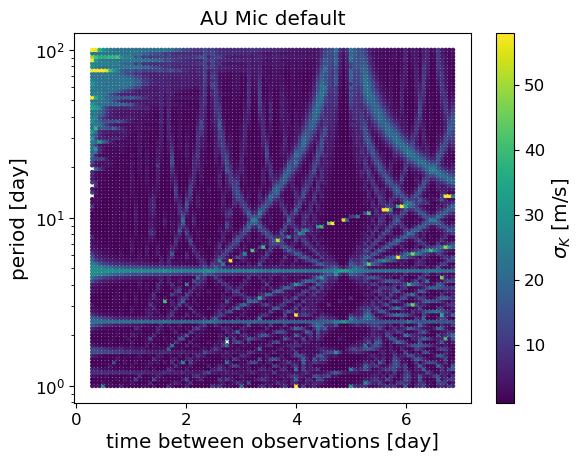

In [88]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks/100, s=5, vmax=58)#, norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=3e4)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r"$\sqrt{Fisher Information on K}$")
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("period [day]")
plt.yscale('log')
plt.title(f"AU Mic default")
plt.savefig(path+"plots/sigmak_regular.pdf", format="pdf")
plt.savefig(path+"plots/sigmak_regular.png", format="png")
plt.show()

#### Beat frequencies

100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 85250.08it/s]


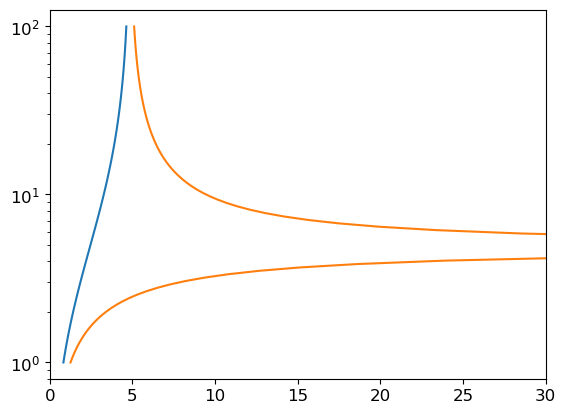

In [89]:
t1s_plus = []
t1s_minus = []
p = 8.46 

for i in tqdm(range(100)):
    c = cadences[i]
    p = periods[i]
    
    t1_plus = 1/((1/Prot) + (1/p))
    t1_minus = 1/((1/Prot) - (1/p))
    t1s_plus.append(t1_plus)
    t1s_minus.append(t1_minus)

plt.plot(t1s_plus, periods) # t3s_plus
plt.plot(np.abs(t1s_minus), periods)
#plt.plot(t1s_plus + np.abs(t1s_minus), periods, color='purple')
plt.xlim([0,30])
#plt.ylim([0, 100])
plt.yscale('log')
plt.show()

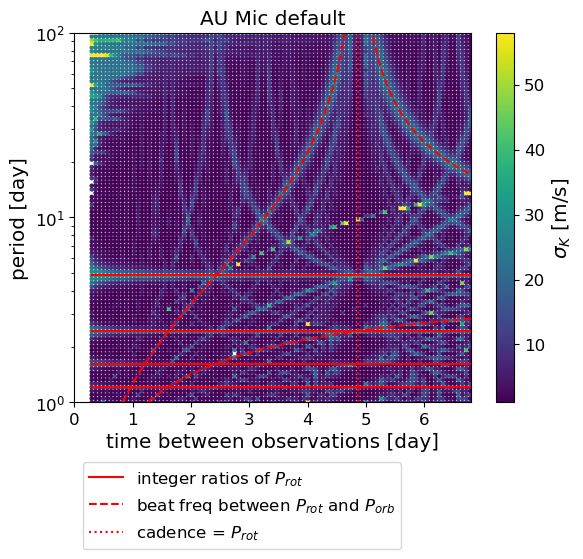

In [91]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks/100, s=5, vmax=58)#, norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=3e4)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r"$\sqrt{Fisher Information on K}$")
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("period [day]")
plt.yscale('log')
plt.ylim([1, 100])
plt.xlim([0, 6.8])
plt.title(f"AU Mic default")


plt.plot(cadences, np.ones(len(cadences))*Prot, color='red', label='integer ratios of $P_{rot}$')
plt.plot(cadences, np.ones(len(cadences))*Prot/2, color='red')
plt.plot(cadences, np.ones(len(cadences))*Prot/3, color='red')
plt.plot(cadences, np.ones(len(cadences))*Prot/4, color='red')

plt.plot(t1s_plus, periods, color='red', linestyle='dashed', label='beat freq between $P_{rot}$ and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t1s_minus), periods, color='red', linestyle='dashed')

plt.plot(np.ones(100)*4.86, np.linspace(1, 100, 100), color='red', linestyle='dotted', label='cadence = $P_{rot}$')

plt.legend(bbox_to_anchor=(0, -0.07, 1, -0.07), loc="upper left")

plt.savefig(path+"plots/beat-freqs.pdf", format="pdf")
plt.savefig(path+"plots/beat-freqs.png", format="png")
plt.show()

#### Tau

In [105]:
# alter a GP hyperparameter
Tau = 30

In [106]:
cadences = np.linspace(0.30, 6.85, 100)
periods = np.logspace(0, 2, 100)
n_obs = 30 #40 # 500

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_p, p in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):    
    
        # instantiate Star object in order to feed covariance matrix with white/correlated noise
        star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                                 Prot = Prot, sigma_qp_rv = sigma_qp_rv)

        # populate list of parameters to feed into cov_matrix_jax()
        params = star.param_list()

        # instantiate Planets object in order to feed Fisher Info calculation machinery
        planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

        # populate list of parameters to feed into clam_jax_fim()
        theta = planet.theta_list()

        # instantiate Strategy object in order to build time series of observations
        strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)

        # build strategy aka time series of observations
        strat = strategy.gappy(c)

        # build covariance matrix, characterized by a correlated noise model of the stellar signal
        kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
        kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
        kernel *= sigma_qp_rv**2 # multiply by scalar

        #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
        #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
        sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
        sigma += 1e-6 

        #print(strat, sigma)
        #fadsfa

        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        inv_fim = inv(fim)

        # top left element of matrix corresponds with RV semi-amplitude, K
        sigma_k = np.sqrt(inv_fim)[0][0]

        sigma_ks[enum_p][enum_c] = sigma_k


  0%|                                                                                   | 0/100 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_21555/75060647.py:53: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


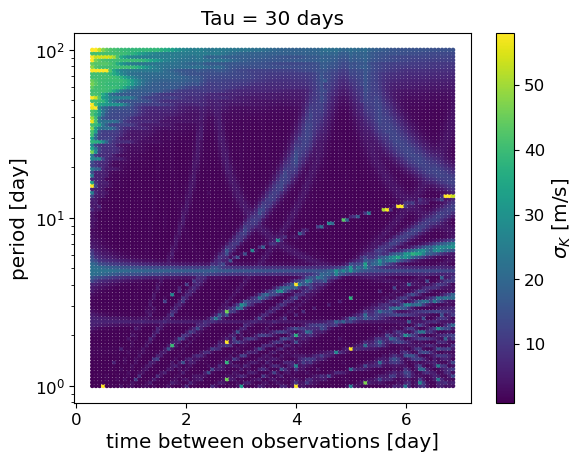

In [108]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks/100, s=5, vmax=58)#, norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=3e4)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r"$\sqrt{Fisher Information on K}$")
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("period [day]")
plt.yscale('log')
plt.title(f"Tau = {Tau:.0f} days")
#plt.savefig(path+"plots/sigmak_tau30.pdf", format="pdf")
#plt.savefig(path+"plots/sigmak_tau30.png", format="png")

plt.show()

#### Prot

In [95]:
# alter a GP hyperparameter
Prot = 28

In [96]:
cadences = np.linspace(0.30, 6.85, 100)
periods = np.logspace(0, 2, 100)
n_obs = 30 #40 # 500

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_p, p in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):    
    
        # instantiate Star object in order to feed covariance matrix with white/correlated noise
        star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                                 Prot = Prot, sigma_qp_rv = sigma_qp_rv)

        # populate list of parameters to feed into cov_matrix_jax()
        params = star.param_list()

        # instantiate Planets object in order to feed Fisher Info calculation machinery
        planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

        # populate list of parameters to feed into clam_jax_fim()
        theta = planet.theta_list()

        # instantiate Strategy object in order to build time series of observations
        strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)

        # build strategy aka time series of observations
        strat = strategy.gappy(c)

        # build covariance matrix, characterized by a correlated noise model of the stellar signal
        kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
        kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
        kernel *= sigma_qp_rv**2 # multiply by scalar

        #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
        #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
        sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
        sigma += 1e-6 

        #print(strat, sigma)
        #fadsfa

        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        inv_fim = inv(fim)

        # top left element of matrix corresponds with RV semi-amplitude, K
        sigma_k = np.sqrt(inv_fim)[0][0]

        sigma_ks[enum_p][enum_c] = sigma_k


  0%|                                                                                   | 0/100 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_21555/75060647.py:53: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


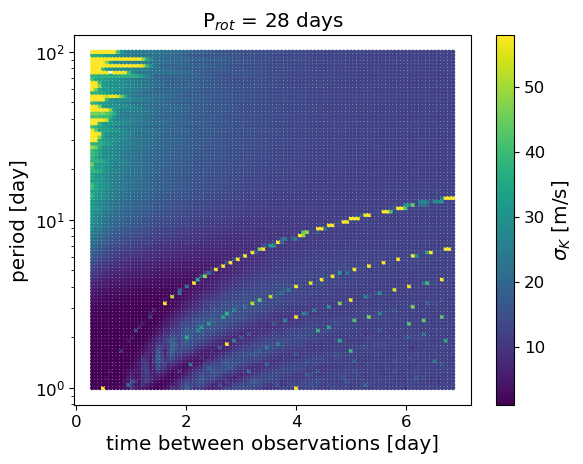

In [97]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks/100, s=5, vmax=58)#, norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=3e4)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r"$\sqrt{Fisher Information on K}$")
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("period [day]")
plt.yscale('log')
plt.title(f"P$_{{rot}}$ = {Prot:.0f} days")
plt.savefig(path+"plots/sigmak_prot28.pdf", format="pdf")
plt.savefig(path+"plots/sigmak_prot28.png", format="png")

plt.show()

#### sigma_qp

In [98]:
Prot = 4.86
sigma_qp_rv = 1000

In [99]:
cadences = np.linspace(0.30, 6.85, 100)
periods = np.logspace(0, 2, 100)
n_obs = 30 #40 # 500

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_p, p in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):    
    
        # instantiate Star object in order to feed covariance matrix with white/correlated noise
        star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                                 Prot = Prot, sigma_qp_rv = sigma_qp_rv)

        # populate list of parameters to feed into cov_matrix_jax()
        params = star.param_list()

        # instantiate Planets object in order to feed Fisher Info calculation machinery
        planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

        # populate list of parameters to feed into clam_jax_fim()
        theta = planet.theta_list()

        # instantiate Strategy object in order to build time series of observations
        strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)

        # build strategy aka time series of observations
        strat = strategy.gappy(c)

        # build covariance matrix, characterized by a correlated noise model of the stellar signal
        kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
        kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
        kernel *= sigma_qp_rv**2 # multiply by scalar

        #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
        #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
        sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
        sigma += 1e-6 

        #print(strat, sigma)
        #fadsfa

        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        inv_fim = inv(fim)

        # top left element of matrix corresponds with RV semi-amplitude, K
        sigma_k = np.sqrt(inv_fim)[0][0]

        sigma_ks[enum_p][enum_c] = sigma_k


  0%|                                                                                   | 0/100 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_21555/75060647.py:53: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


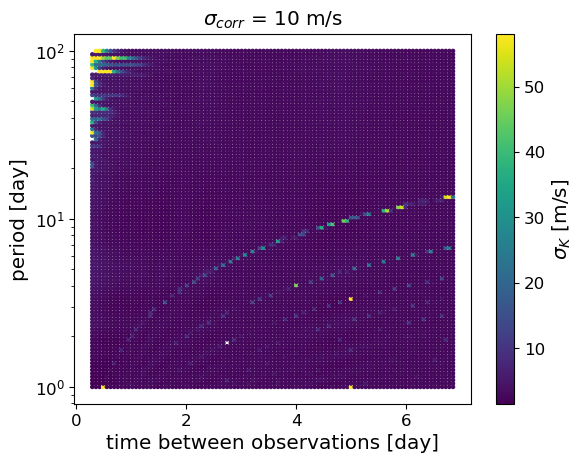

In [100]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks/100, s=5, vmax=58)#, norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=3e4)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r"$\sqrt{Fisher Information on K}$")
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("period [day]")
plt.yscale('log')
plt.title(f"$\sigma_{{corr}}$ = {sigma_qp_rv/100:.0f} m/s")
plt.savefig(path+"plots/sigmak_sigma_qp1000.pdf", format="pdf")
plt.savefig(path+"plots/sigmak_sigma_qp1000.png", format="png")

plt.show()

#### eta

In [101]:
sigma_qp_rv = 4700
eta = 0.9

In [102]:
cadences = np.linspace(0.30, 6.85, 100)
periods = np.logspace(0, 2, 100)
n_obs = 30 #40 # 500

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_p, p in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):    
    
        # instantiate Star object in order to feed covariance matrix with white/correlated noise
        star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                                 Prot = Prot, sigma_qp_rv = sigma_qp_rv)

        # populate list of parameters to feed into cov_matrix_jax()
        params = star.param_list()

        # instantiate Planets object in order to feed Fisher Info calculation machinery
        planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

        # populate list of parameters to feed into clam_jax_fim()
        theta = planet.theta_list()

        # instantiate Strategy object in order to build time series of observations
        strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)

        # build strategy aka time series of observations
        strat = strategy.gappy(c)

        # build covariance matrix, characterized by a correlated noise model of the stellar signal
        kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
        kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
        kernel *= sigma_qp_rv**2 # multiply by scalar

        #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
        #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
        sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
        sigma += 1e-6 

        #print(strat, sigma)
        #fadsfa

        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        inv_fim = inv(fim)

        # top left element of matrix corresponds with RV semi-amplitude, K
        sigma_k = np.sqrt(inv_fim)[0][0]

        sigma_ks[enum_p][enum_c] = sigma_k


  0%|                                                                                   | 0/100 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_21555/75060647.py:53: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


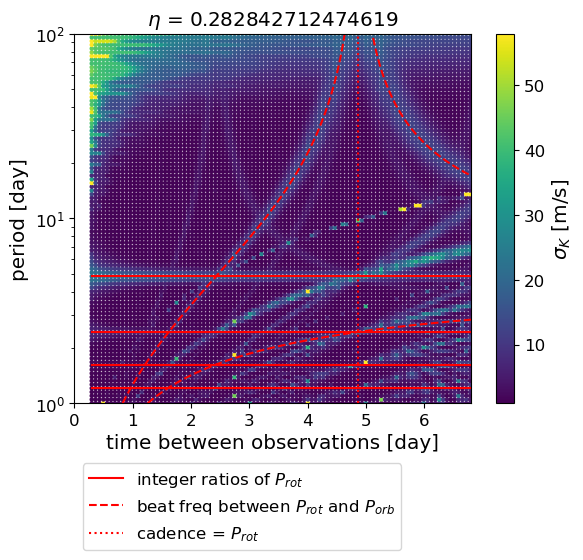

In [116]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks/100, s=5, vmax=58)#, norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=3e4)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r"$\sqrt{Fisher Information on K}$")
cbar.ax.set_ylabel(r"$\sigma_K$ [m/s]")
plt.xlabel("time between observations [day]")
plt.ylabel("period [day]")
plt.yscale('log')
plt.ylim([1, 100])
plt.xlim([0, 6.8])
plt.title(f"$\eta$ = {eta}")


plt.plot(cadences, np.ones(len(cadences))*Prot, color='red', label='integer ratios of $P_{rot}$')
plt.plot(cadences, np.ones(len(cadences))*Prot/2, color='red')
plt.plot(cadences, np.ones(len(cadences))*Prot/3, color='red')
plt.plot(cadences, np.ones(len(cadences))*Prot/4, color='red')

plt.plot(t1s_plus, periods, color='red', linestyle='dashed', label='beat freq between $P_{rot}$ and $P_{orb}$') # t3s_plus
plt.plot(np.abs(t1s_minus), periods, color='red', linestyle='dashed')

plt.plot(np.ones(100)*4.86, np.linspace(1, 100, 100), color='red', linestyle='dotted', label='cadence = $P_{rot}$')

plt.legend(bbox_to_anchor=(0, -0.07, 1, -0.07), loc="upper left")


#plt.savefig(path+"plots/sigmak_eta09.pdf", format="pdf")
plt.savefig(path+"plots/sigmak_eta09.png", format="png")

plt.show()